## DEX US EU

In [41]:
%load_ext autoreload
%autoreload 2

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from random_walk_model import (
    discretise_Wt,
    simulate_multiple_discrete_paths,
    forecast_from_multiple_paths,
    plot_multiple_paths_vs_history
)

# Read the CSV file from the preprocessing folder
train_df = pd.read_csv('../2. preprocesing/train_df_dexuseu.csv', index_col=0, parse_dates=True)

# Show the first rows
train_df.head()


,rate,rate_interpolated,log_rate,diff,Wt
date,,,,,
2015-01-06,1.1936,1.1936,0.176974,0.001509,0.001513
2015-01-07,1.1820,1.1820,0.167208,-0.009766,-0.009762
2015-01-08,1.1811,1.1811,0.166446,-0.000762,-0.000758
2015-01-09,1.1830,1.1830,0.168054,0.001607,0.001611
2015-01-12,1.1832,1.1832,0.168223,0.000169,0.000173


### Random Walk

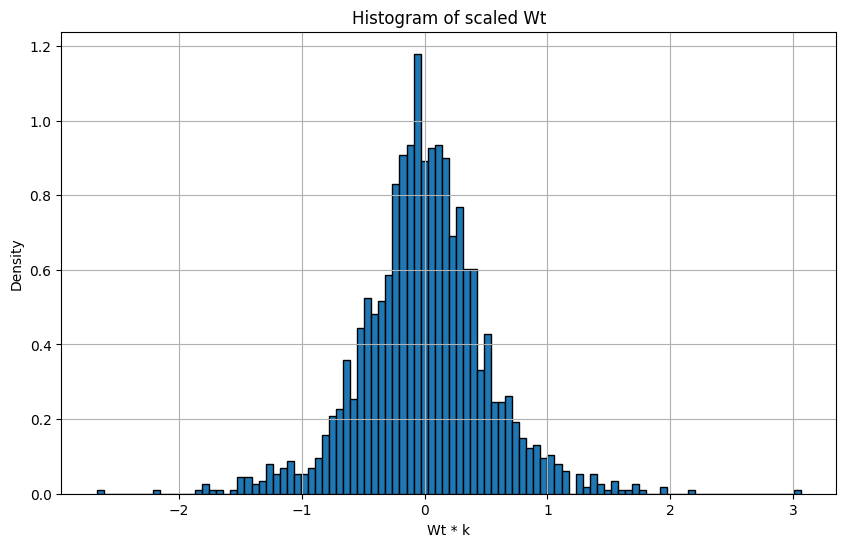

count    1996.000000
mean       -0.000050
std         0.005110
min        -0.026720
25%        -0.002754
50%        -0.000168
75%         0.002785
max         0.030646
Name: Wt, dtype: float64


In [43]:
k = 100
df= train_df.copy()
df['scaled_Wt'] = df['Wt'] * k
# basic histogram of the scaled Wt
plt.figure(figsize=(10,6))
plt.hist(df['scaled_Wt'], bins=100, edgecolor='black', density=True)
plt.title('Histogram of scaled Wt')
plt.xlabel('Wt * k')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# statistics of the original Wt
print(df['Wt'].describe())

Empirical probabilities:
P(-1) = 0.1363, P(0) = 0.7355, P(+1) = 0.1283


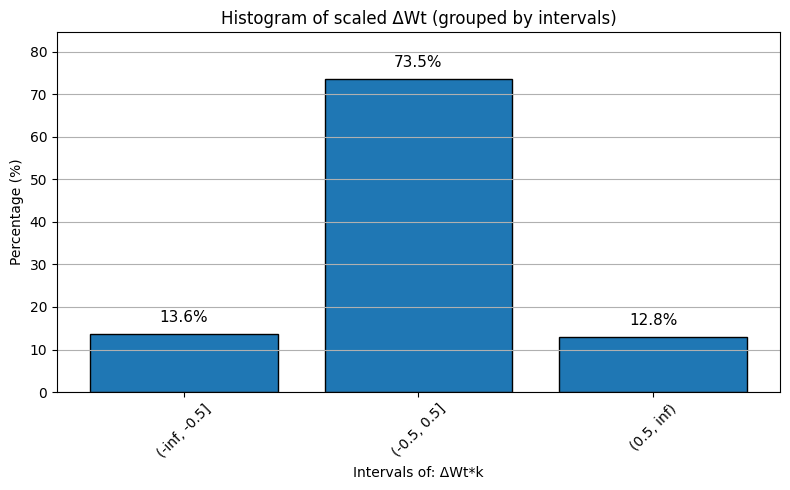

,rate,rate_interpolated,log_rate,diff,Wt,scaled_Wt,e_t,scaled_Wt_bin
date,,,,,,,,
2015-01-06,1.1936,1.1936,0.176974,0.001509,0.001513,0.151297,0,"(-0.5, 0.5]"
2015-01-07,1.1820,1.1820,0.167208,-0.009766,-0.009762,-0.976224,-1,"(-inf, -0.5]"
2015-01-08,1.1811,1.1811,0.166446,-0.000762,-0.000758,-0.075792,0,"(-0.5, 0.5]"
2015-01-09,1.1830,1.1830,0.168054,0.001607,0.001611,0.161117,0,"(-0.5, 0.5]"
2015-01-12,1.1832,1.1832,0.168223,0.000169,0.000173,0.017284,0,"(-0.5, 0.5]"
...,...,...,...,...,...,...,...,...
2022-12-23,1.0621,1.0621,0.060248,0.003112,0.003116,0.311568,0,"(-0.5, 0.5]"
2022-12-27,1.0654,1.0654,0.063350,0.003102,0.003106,0.310603,0,"(-0.5, 0.5]"
2022-12-28,1.0622,1.0622,0.060342,-0.003008,-0.003004,-0.300429,0,"(-0.5, 0.5]"


In [ ]:
# ----------------------------------------
# with DEXUSEU training data
# ----------------------------------------

# Read the CSV file from the preprocessing folder
train_df = pd.read_csv('../2. preprocesing/train_df_dexuseu.csv', index_col=0, parse_dates=True)
# Step 1: Discretise Wt and get probabilities
k=100
train_df_dexuseu, p_dict = discretise_Wt(train_df, k=k)

train_df_dexuseu


In [45]:
# Manual assigning of probabilities for the example
# p_dict = {-1: 0.27055, 0: 0.4589, 1: 0.27055}
p_dict = {-1: 0.13, 0: 0.74, 1: 0.13}

# Step 2: Simulate one 2-year path
paths = simulate_multiple_discrete_paths(
    start_value=train_df_dexuseu['scaled_Wt'].iloc[-1],
    p_dict=p_dict,
    horizon=365*2,      # simulate 2 years
    n_paths=1000,
    seed=42
)

In [46]:
# forecast paths: 
estimated_mu = -0.000004  # this must be your actual drift!

df_paths = forecast_from_multiple_paths(
    train_df=train_df_dexuseu, # historical data
    paths=paths,    # the simulated paths
    k=k,            # the same K value
    mu=estimated_mu # this must be your actual drift!
)

In [47]:
df_paths

,2022-12-31,2023-01-01,2023-01-02,2023-01-03,2023-01-04,2023-01-05,2023-01-06,2023-01-07,2023-01-08,2023-01-09,...,2024-12-20,2024-12-21,2024-12-22,2024-12-23,2024-12-24,2024-12-25,2024-12-26,2024-12-27,2024-12-28,2024-12-29
0,1.069796,1.059147,1.059143,1.059138,1.048596,1.038158,1.038154,1.038149,1.038145,1.038141,...,1.454392,1.439914,1.439909,1.439903,1.439897,1.439891,1.454357,1.454351,1.454345,1.454339
1,1.059151,1.059147,1.059143,1.059138,1.059134,1.059130,1.069770,1.069766,1.080513,1.080508,...,1.110253,1.110248,1.110244,1.110239,1.110235,1.099184,1.099179,1.110222,1.110217,1.110213
2,1.069796,1.069791,1.069787,1.069783,1.069779,1.069774,1.069770,1.069766,1.069761,1.069757,...,0.974908,0.974904,0.974900,0.974896,0.974892,0.974888,0.974884,0.984678,0.984674,0.984670
3,1.069796,1.080543,1.080539,1.080534,1.080530,1.080526,1.080521,1.080517,1.080513,1.080508,...,1.289930,1.289925,1.302883,1.302878,1.289909,1.289904,1.289899,1.289894,1.277054,1.277049
4,1.069796,1.069791,1.059143,1.048600,1.048596,1.048591,1.048587,1.038149,1.038145,1.038141,...,1.155563,1.155558,1.167167,1.167163,1.167158,1.167153,1.167149,1.167144,1.167139,1.167135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.059151,1.059147,1.059143,1.059138,1.059134,1.059130,1.059126,1.059121,1.048579,1.059113,...,0.974908,0.984702,0.984698,0.984694,0.994586,0.994582,0.994578,0.994574,0.994571,0.994567
996,1.069796,1.069791,1.069787,1.069783,1.069779,1.080526,1.080521,1.080517,1.080513,1.080508,...,1.121411,1.121407,1.121402,1.121398,1.121393,1.110231,1.110226,1.110222,1.110217,1.110213
997,1.069796,1.069791,1.069787,1.059138,1.059134,1.059130,1.059126,1.048583,1.048579,1.059113,...,1.178907,1.190750,1.190746,1.190741,1.190736,1.190731,1.190727,1.190722,1.190717,1.190712
998,1.080547,1.080543,1.069787,1.069783,1.080530,1.080526,1.080521,1.080517,1.080513,1.080508,...,0.814312,0.814308,0.814305,0.806199,0.806196,0.806193,0.814292,0.822472,0.822469,0.822466


In [48]:
# Export df_forecast for DEXUSEU to CSV
df_paths.index.name = 'date'
df_paths.to_csv('df_forecast_dexuseu.csv')

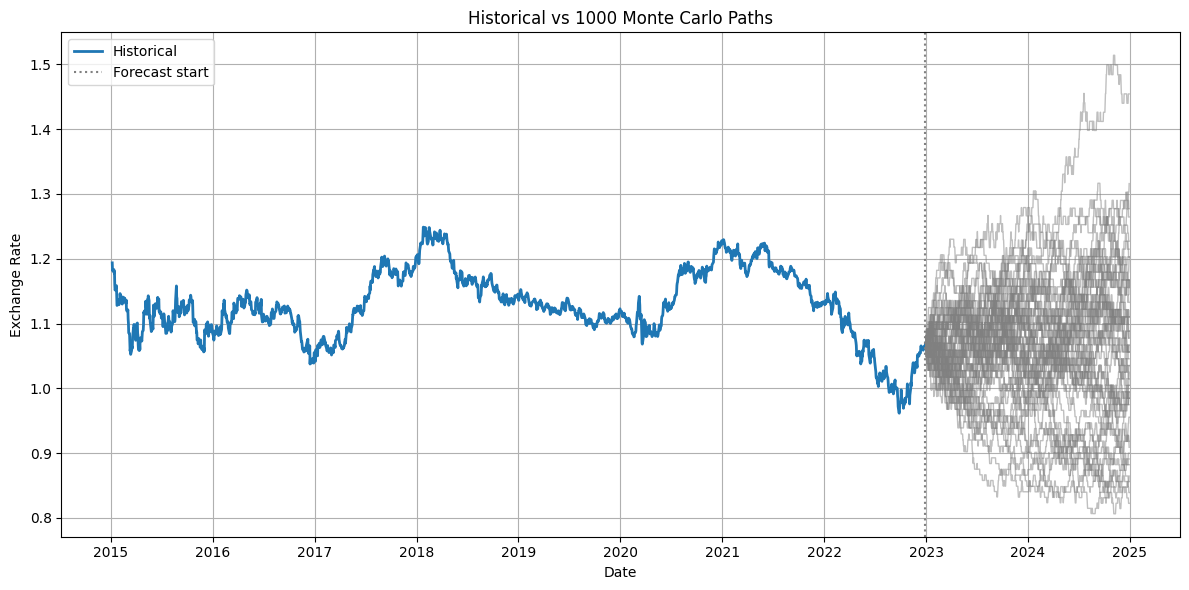

In [49]:
plot_multiple_paths_vs_history(train_df_dexuseu, df_paths, n_show=50)

### ARIMA model

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# train_df is already loaded with index as date
series = train_df['log_rate'] # or diff? or Wt?


In [18]:
# DETERMINE d (differencing order) using ADF and KPSS tests
from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")


# with pmdarima helper:
d_adf = ndiffs(train_df['log_rate'], test='adf')
# d_kpss = ndiffs(train_df['log_rate'], test='kpss')
print("Recommended d (ADF):", d_adf)
# print("Recommended d (KPSS):", d_kpss)

# Direct ADF test  Augmented Dickey-Fuller already done in preprocessing
adf_res = adfuller(train_df['log_rate'])
print("ADF p-value:", adf_res[1])



Recommended d (ADF): 1
ADF p-value: 0.29173970051408926


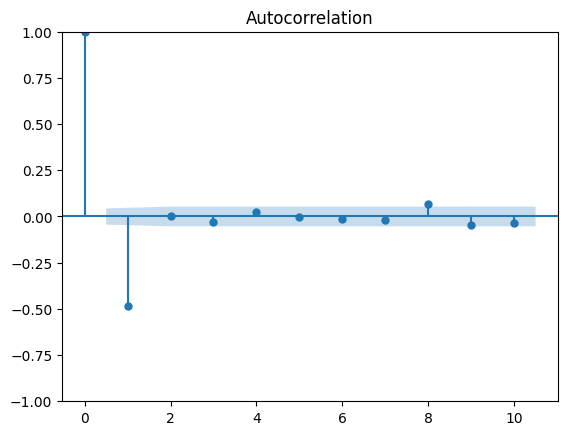

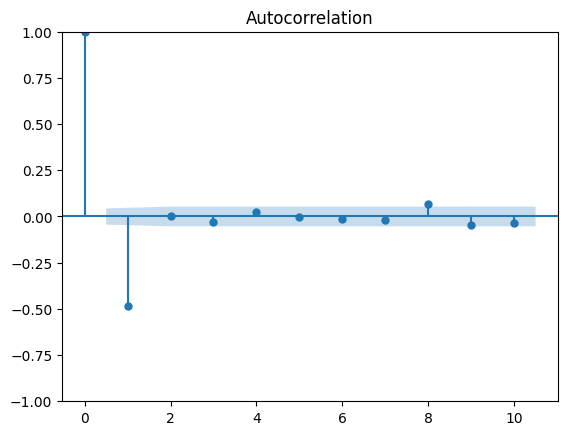

In [45]:
# selct q with ACF autocorrelation function
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
d=1
diff_series = train_df['Wt'].diff(d).dropna()

plot_acf(diff_series, lags=10)




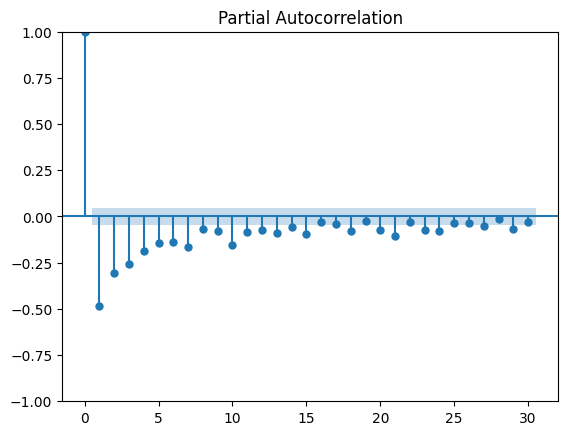

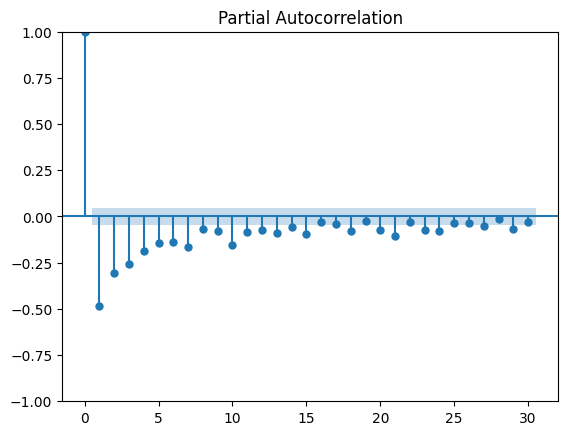

In [47]:
# for select p with PACF partial autocorrelation function
plot_pacf(diff_series, lags=30)

In [29]:
# estimate and compare models
from statsmodels.tsa.arima.model import ARIMA

d = 1

# Model 1: ARIMA(1,1,0)
model_110 = ARIMA(train_df['log_rate'], order=(1, d, 0))
res_110 = model_110.fit()
print('ARIMA(1,1,0) AIC =', res_110.aic)

# Model 2: ARIMA(0,1,1)
model_011 = ARIMA(train_df['log_rate'], order=(0, d, 1))
res_011 = model_011.fit()
print('ARIMA(0,1,1) AIC =', res_011.aic)

# Model 3: ARIMA(1,1,1)
model_111 = ARIMA(train_df['log_rate'], order=(1, d, 1))
res_111 = model_111.fit()
print('ARIMA(1,1,1) AIC =', res_111.aic)

# Model 4: ARIMA(2,1,1)
model_211 = ARIMA(train_df['log_rate'], order=(2, d, 1))
res_211 = model_211.fit()
print('ARIMA(2,1,1) AIC =', res_211.aic)

# Model 4: ARIMA(1,1,2)
model_112 = ARIMA(train_df['log_rate'], order=(1, d, 2))
res_112 = model_112.fit()
print('ARIMA(1,1,2) AIC =', res_112.aic)


ARIMA(1,1,0) AIC = -15389.663874436184
ARIMA(0,1,1) AIC = -15389.651160555617
ARIMA(1,1,1) AIC = -15387.669184346814
ARIMA(2,1,1) AIC = -15383.608386870259
ARIMA(1,1,2) AIC = -15385.735910201063


In [24]:
res_best = res_110  # por ejemplo
print(res_best.summary())


                               SARIMAX Results                                
Dep. Variable:               log_rate   No. Observations:                 1996
Model:                 ARIMA(1, 1, 0)   Log Likelihood                7696.832
Date:                Wed, 23 Jul 2025   AIC                         -15389.664
Time:                        11:38:17   BIC                         -15378.467
Sample:                             0   HQIC                        -15385.552
                               - 1996                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0321      0.018      1.740      0.082      -0.004       0.068
sigma2      2.605e-05   5.67e-07     45.952      0.000    2.49e-05    2.72e-05
Ljung-Box (L1) (Q):                   0.00   Jarque-

In [ ]:
# Interpretation:

# ar.L1 (coef = 0.0321): a small positive AR(1) effect.
# std err (0.018): standard error of the coefficient.
# z = 1.740 and P>|z| = 0.082: the test statistic and p-value for H0: coefficient = 0. 
# Since p = 0.082 > 0.05, ar.L1 is not statistically significant at 5% (there’s ~8.2% chance the coefficient is zero).


# [0.975 & 0.025]: 95 % confidence interval for each parameter:
# For ar.L1: from –0.004 to 0.068 → interval crosses zero → not significant.
# For sigma2: its narrow interval (2.49e‑05 – 2.72e‑05) is always > 0 → noise variance significantly non-zero.

In [ ]:
# Ljung‑Box (L1) Q = 0.00, Prob(Q) = 0.99
# — Tests autocorrelation of residuals. High p‑value (0.99) → cannot reject null → residuals behave like white noise.

# Jarque–Bera (JB) = 413.49, Prob(JB) = 0.00
# — Tests normality. p‑value 0 → residuals are not normally distributed (non-normality indicated).

# Heteroskedasticity (H) = 0.59, Prob(H) = 0.00
# — Tests constant variance. p‑value 0 → residuals have non-constant variance (heteroskedastic).

# Skew = 0.04, Kurtosis = 5.23
# — Slightly heavier tails (kurtosis > 3), mild asymmetry.

<Figure size 640x480 with 0 Axes>

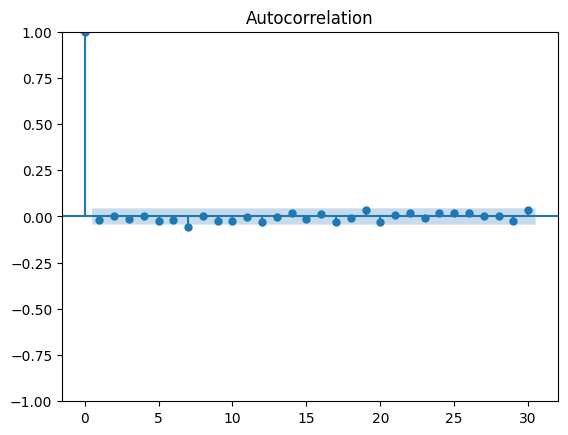

In [ ]:
# checking autocorrelation of residuals
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

resid = res_best.resid
plt.figure(); plot_acf(resid.dropna(), lags=30)
plt.show()



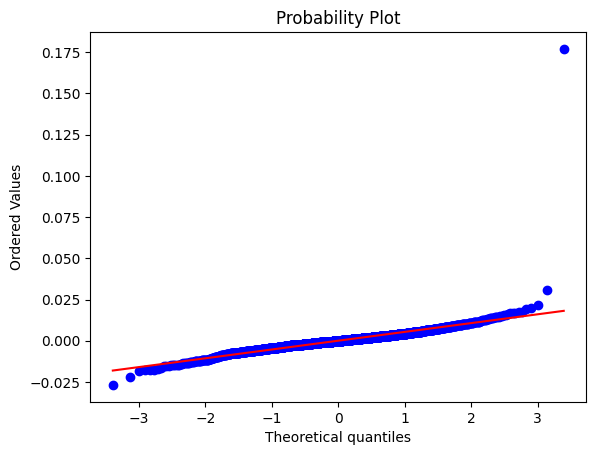

In [ ]:
# checking normality of residuals
import scipy.stats as stats
import matplotlib.pyplot as plt

stats.probplot(resid.dropna(), dist="norm", plot=plt)
plt.show()


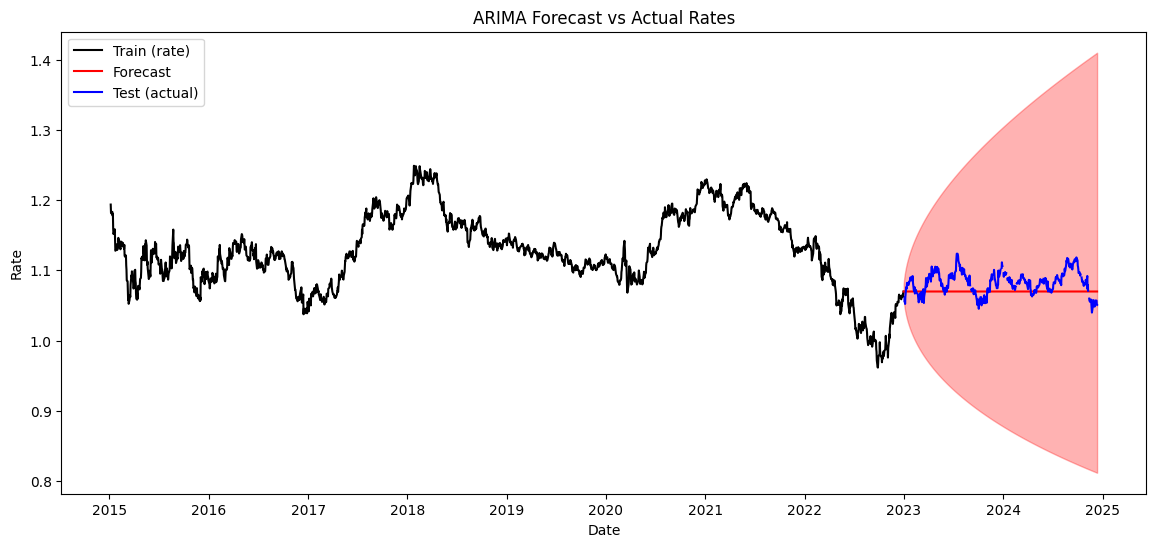

In [43]:
import pandas as pd

# Load test data
test_df = pd.read_csv('../2. preprocesing/test_df_dexuseu.csv', index_col='date', parse_dates=True)

last_train_date = train_df.index.max()  # e.g. 2022‑12‑31
start_fc = last_train_date + pd.Timedelta(days=1)
steps = 712  # 356*2

# Forecast in log scale
fc = res_best.get_forecast(steps=steps)
fc_index = pd.date_range(start=start_fc, periods=steps, freq='D')

fc_log = pd.Series(fc.predicted_mean.values, index=fc_index, name='fc_log_rate')
ci = fc.conf_int()
ci.index = fc_index
ci.columns = ['lower_log_rate', 'upper_log_rate']

# Transform back to rate
fc_rate = np.exp(fc_log)
ci_lower = np.exp(ci['lower_log_rate'])
ci_upper = np.exp(ci['upper_log_rate'])

# Align test data
test_rate = test_df['rate'].loc[start_fc:start_fc + pd.Timedelta(days=steps-1)]

# Plot results
plt.figure(figsize=(14,6))
plt.plot(train_df['rate'], label='Train (rate)', color='black')
plt.plot(fc_rate, label='Forecast', color='red')
plt.fill_between(fc_rate.index, ci_lower, ci_upper, color='red', alpha=0.3)
plt.plot(test_rate, label='Test (actual)', color='blue')
plt.title('ARIMA Forecast vs Actual Rates')
plt.xlabel('Date')
plt.ylabel('Rate')
plt.legend()
plt.show()


## DEX US SF

In [142]:
# Read the CSV file from the preprocessing folder
train_df = pd.read_csv('../2. preprocesing/train_df_dexussf.csv', index_col=0, parse_dates=True)

# Show the first rows
train_df.head()

,rate,rate_interpolated,log_rate,diff,Wt
date,,,,,
2015-01-06,0.085466,0.085466,-2.459632,0.001281,0.001404
2015-01-07,0.085415,0.085415,-2.460230,-0.000598,-0.000475
2015-01-08,0.086558,0.086558,-2.446945,0.013285,0.013408
2015-01-09,0.087070,0.087070,-2.441042,0.005903,0.006026
2015-01-12,0.086760,0.086760,-2.444605,-0.003564,-0.003440


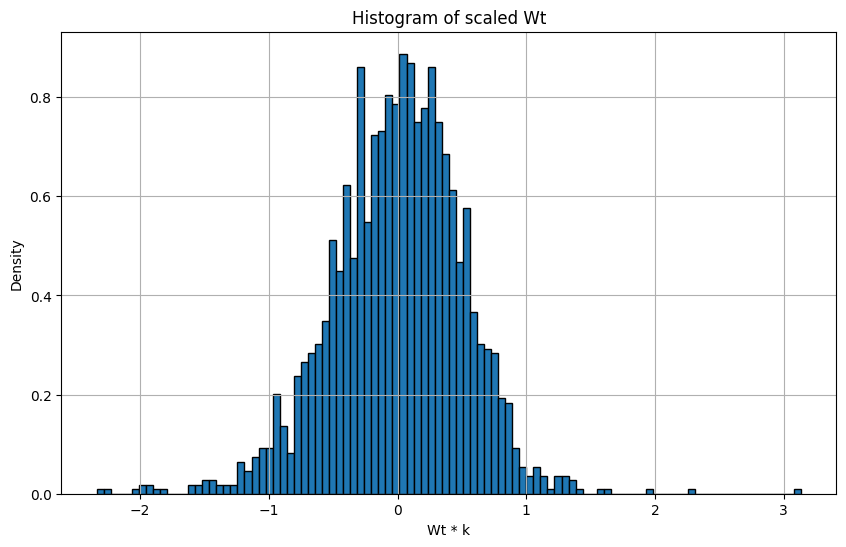

count    1996.000000
mean       -0.000063
std         0.010218
min        -0.046778
25%        -0.006204
50%         0.000465
75%         0.006662
max         0.062697
Name: Wt, dtype: float64


In [143]:
k = 50
df= train_df.copy()
df['scaled_Wt'] = df['Wt'] * k
# basic histogram of the scaled Wt
plt.figure(figsize=(10,6))
plt.hist(df['scaled_Wt'], bins=100, edgecolor='black', density=True)
plt.title('Histogram of scaled Wt')
plt.xlabel('Wt * k')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# statistics of the original Wt
print(df['Wt'].describe())

Empirical probabilities:
P(-1) = 0.1518, P(0) = 0.6999, P(+1) = 0.1483


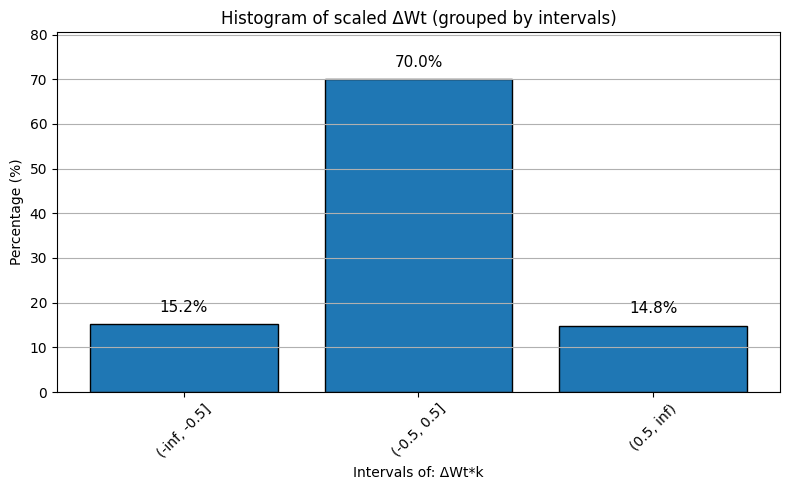

,rate,rate_interpolated,log_rate,diff,Wt,scaled_Wt,e_t,scaled_Wt_bin
date,,,,,,,,
2015-01-06,0.085466,0.085466,-2.459632,0.001281,0.001404,0.070212,0,"(-0.5, 0.5]"
2015-01-07,0.085415,0.085415,-2.460230,-0.000598,-0.000475,-0.023751,0,"(-0.5, 0.5]"
2015-01-08,0.086558,0.086558,-2.446945,0.013285,0.013408,0.670379,1,"(0.5, inf)"
2015-01-09,0.087070,0.087070,-2.441042,0.005903,0.006026,0.301319,0,"(-0.5, 0.5]"
2015-01-12,0.086760,0.086760,-2.444605,-0.003564,-0.003440,-0.172023,0,"(-0.5, 0.5]"
...,...,...,...,...,...,...,...,...
2022-12-23,0.058919,0.058919,-2.831594,0.009966,0.010089,0.504472,1,"(0.5, inf)"
2022-12-27,0.057793,0.057793,-2.850880,-0.019286,-0.019162,-0.958122,-1,"(-inf, -0.5]"
2022-12-28,0.058428,0.058428,-2.839955,0.010925,0.011048,0.552384,1,"(0.5, inf)"


In [144]:
# Step 1: Discretise Wt and get probabilities
train_df_dexuseu, p_dict = discretise_Wt(train_df, k=k)

train_df_dexuseu

In [145]:
# Manual assigning of probabilities for the example
# p_dict = {-1: 0.27055, 0: 0.4589, 1: 0.27055}
p_dict = {-1: 0.15, 0: 0.7, 1: 0.15}

# Step 2: Simulate one 2-year path
path = simulate_one_discrete_path(
    start_value=train_df_dexuseu['scaled_Wt'].iloc[-1],
    p_dict=p_dict,
    horizon=365*2,  # 2 years ≈ 504 trading days
    seed=24
)
paths = simulate_multiple_discrete_paths(
    start_value=train_df_dexuseu['scaled_Wt'].iloc[-1],
    p_dict=p_dict,
    horizon=365*2,      # simulate 2 years
    n_paths=1000,
    seed=42
)

In [146]:
# Assume:
# - path is your simulated scaled_Wt
# - k = 50
# - mu was estimated via linear regression on log_rate -0.000123
estimated_mu = -0.000123  # this must be your actual drift!

df_forecast_summary = forecast_from_multiple_paths(
    train_df=train_df_dexuseu,
    paths=paths,
    k=k,
    mu=estimated_mu
)

df_forecast = forecast_exchange_rate_from_simulation(
    train_df=train_df_dexuseu,
    simulated_path=path,
    k=k,
    mu=estimated_mu # this must be your actual drift!
)


In [147]:
df_forecast_summary

,log_rate_mean,log_rate_lower,log_rate_upper,rate_mean,rate_lower,rate_upper
2022-12-31,-2.832482,-2.853042,-2.813042,0.058870,0.057669,0.060022
2023-01-01,-2.833065,-2.853165,-2.793165,0.058839,0.057662,0.061227
2023-01-02,-2.833428,-2.873288,-2.793288,0.058822,0.056513,0.061220
2023-01-03,-2.833631,-2.873411,-2.793411,0.058813,0.056506,0.061212
2023-01-04,-2.834034,-2.873534,-2.793534,0.058793,0.056499,0.061205
...,...,...,...,...,...,...
2024-12-25,-2.924717,-3.502217,-2.362217,0.056073,0.030131,0.094211
2024-12-26,-2.924900,-3.502340,-2.362340,0.056071,0.030127,0.094200
2024-12-27,-2.925123,-3.502463,-2.362463,0.056054,0.030123,0.094188
2024-12-28,-2.925326,-3.502586,-2.362586,0.056040,0.030119,0.094176


In [148]:
# Export df_forecast for DEXUSEU to CSV
df_forecast_summary.index.name = 'date'
df_forecast_summary.to_csv('df_forecast_dexussf.csv')

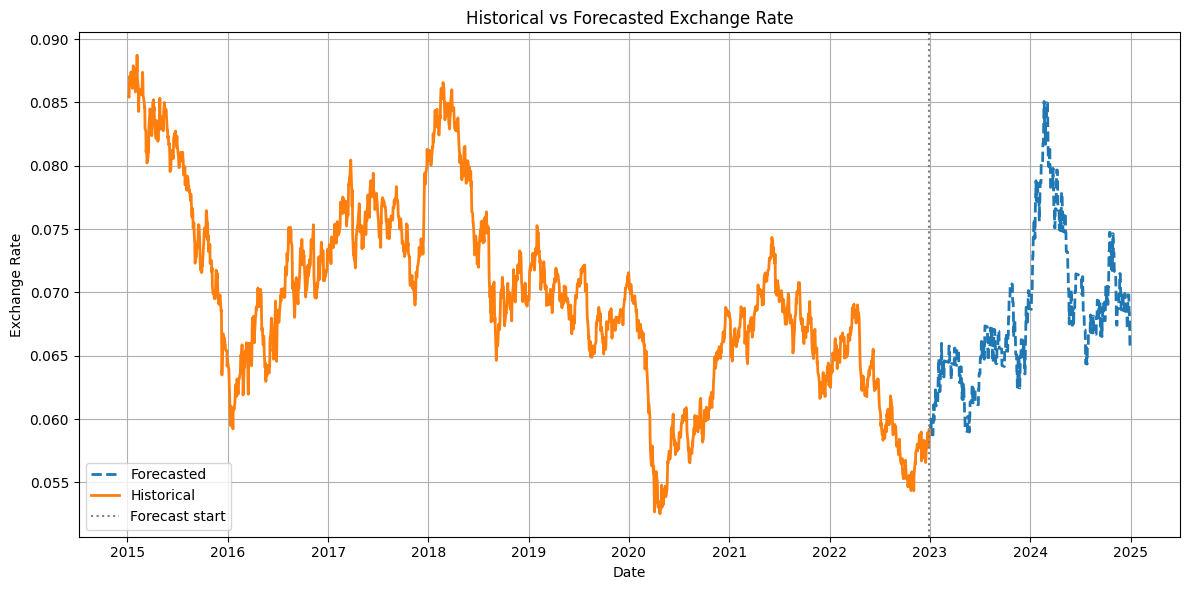

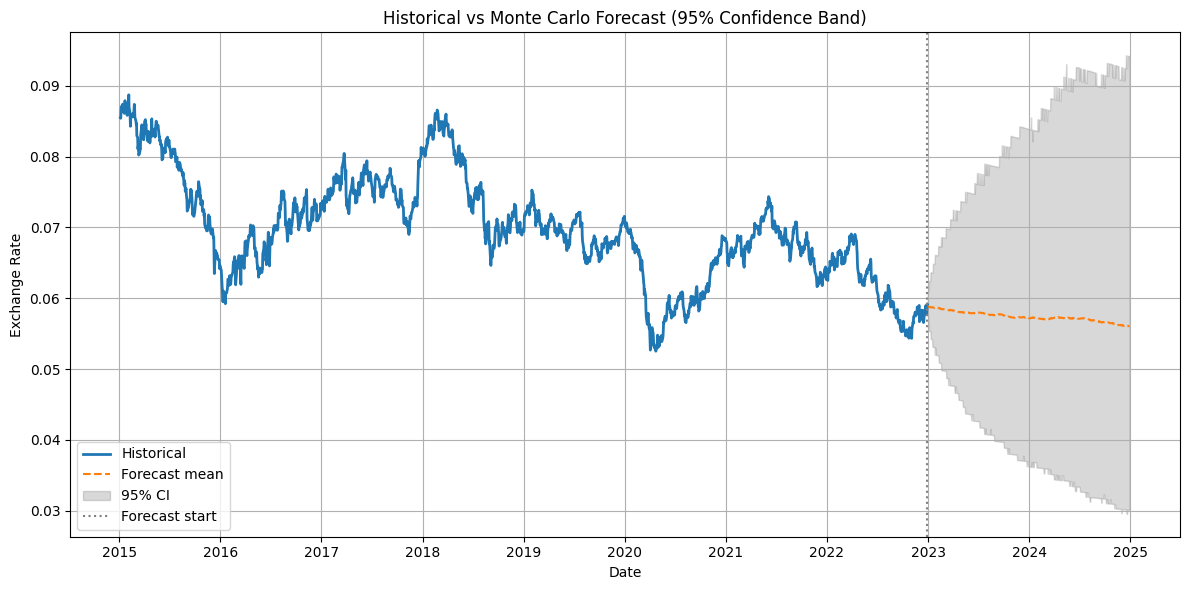

In [149]:
combined_df = plot_forecast_vs_history(train_df_dexuseu, df_forecast, rate_col='rate', rate_pred_col='rate_pred')
combined_df = plot_forecast_summary_vs_history(train_df_dexuseu, df_forecast_summary)


In [150]:
combined_df

,rate,source
date,,
2015-01-06,0.085466,Historical
2015-01-07,0.085415,Historical
2015-01-08,0.086558,Historical
2015-01-09,0.087070,Historical
2015-01-12,0.086760,Historical
...,...,...
2024-12-25,0.056073,Forecasted
2024-12-26,0.056071,Forecasted
2024-12-27,0.056054,Forecasted


## DEX US PEN

In [151]:
# Read the CSV file from the preprocessing folder
train_df = pd.read_csv('../2. preprocesing/train_df_usdpen.csv', index_col=0, parse_dates=True)

# Show the first rows
train_df.head()

,rate,rate_interpolated,log_rate,diff,Wt
date,,,,,
2015-01-07,0.334784,0.334784,-1.094270,-0.001340,-0.001232
2015-01-08,0.334560,0.334560,-1.094939,-0.000669,-0.000562
2015-01-09,0.334896,0.334896,-1.093935,0.001004,0.001112
2015-01-12,0.334560,0.334560,-1.094939,-0.001004,-0.000896
2015-01-13,0.335008,0.335008,-1.093600,0.001339,0.001447


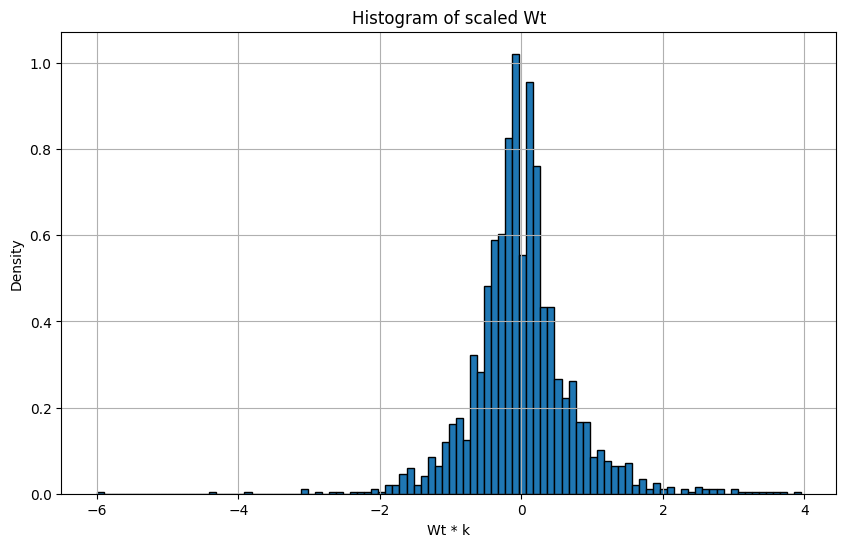

count    1996.000000
mean       -0.000016
std         0.003623
min        -0.030015
25%        -0.001727
50%        -0.000188
75%         0.001528
max         0.019757
Name: Wt, dtype: float64


In [152]:
k = 200
df= train_df.copy()
df['scaled_Wt'] = df['Wt'] * k
# basic histogram of the scaled Wt
plt.figure(figsize=(10,6))
plt.hist(df['scaled_Wt'], bins=100, edgecolor='black', density=True)
plt.title('Histogram of scaled Wt')
plt.xlabel('Wt * k')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# statistics of the original Wt
print(df['Wt'].describe())

Empirical probabilities:
P(-1) = 0.1759, P(0) = 0.6603, P(+1) = 0.1638


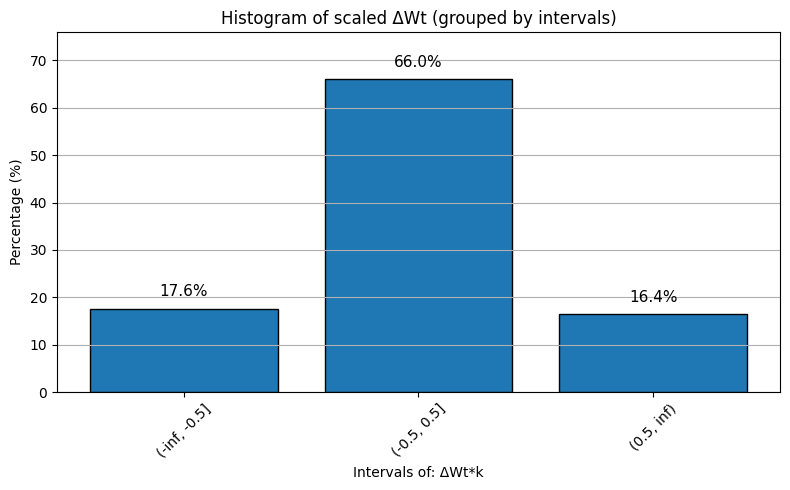

,rate,rate_interpolated,log_rate,diff,Wt,scaled_Wt,e_t,scaled_Wt_bin
date,,,,,,,,
2015-01-07,0.334784,0.334784,-1.094270,-0.001340,-0.001232,-0.246452,0,"(-0.5, 0.5]"
2015-01-08,0.334560,0.334560,-1.094939,-0.000669,-0.000562,-0.112314,0,"(-0.5, 0.5]"
2015-01-09,0.334896,0.334896,-1.093935,0.001004,0.001112,0.222392,0,"(-0.5, 0.5]"
2015-01-12,0.334560,0.334560,-1.094939,-0.001004,-0.000896,-0.179282,0,"(-0.5, 0.5]"
2015-01-13,0.335008,0.335008,-1.093600,0.001339,0.001447,0.289382,0,"(-0.5, 0.5]"
...,...,...,...,...,...,...,...,...
2022-12-26,0.261575,0.261575,-1.341035,0.001046,0.001154,0.230705,0,"(-0.5, 0.5]"
2022-12-27,0.261643,0.261643,-1.340774,0.000262,0.000369,0.073877,0,"(-0.5, 0.5]"
2022-12-28,0.261986,0.261986,-1.339465,0.001309,0.001417,0.283369,0,"(-0.5, 0.5]"


In [153]:
# Step 1: Discretise Wt and get probabilities
train_df_dexuseu, p_dict = discretise_Wt(train_df, k=k)

train_df_dexuseu

In [154]:
# Manual assigning of probabilities for the example
# p_dict = {-1: 0.27055, 0: 0.4589, 1: 0.27055}
p_dict = {-1: 0.17, 0: 0.66, 1: 0.17}

# Step 2: Simulate one 2-year path
path = simulate_one_discrete_path(
    start_value=train_df_dexuseu['scaled_Wt'].iloc[-1],
    p_dict=p_dict,
    horizon=365*2,  # 2 years ≈ 504 trading days
    seed=24
)
paths = simulate_multiple_discrete_paths(
    start_value=train_df_dexuseu['scaled_Wt'].iloc[-1],
    p_dict=p_dict,
    horizon=365*2,      # simulate 2 years
    n_paths=1000,
    seed=42
)

In [155]:
# Assume:
# - path is your simulated scaled_Wt
# - k = 50
# - mu was estimated via linear regression on log_rate -0.000123
estimated_mu = -0.000123  # this must be your actual drift!

df_forecast_summary = forecast_from_multiple_paths(
    train_df=train_df_dexuseu,
    paths=paths,
    k=k,
    mu=estimated_mu
)

df_forecast = forecast_exchange_rate_from_simulation(
    train_df=train_df_dexuseu,
    simulated_path=path,
    k=k,
    mu=estimated_mu # this must be your actual drift!
)

In [156]:
df_forecast_summary

,log_rate_mean,log_rate_lower,log_rate_upper,rate_mean,rate_lower,rate_upper
2022-12-31,-1.340223,-1.345373,-1.335373,0.261788,0.260442,0.263060
2023-01-01,-1.340446,-1.350496,-1.330496,0.261731,0.259112,0.264346
2023-01-02,-1.340609,-1.350619,-1.330619,0.261690,0.259080,0.264313
2023-01-03,-1.340727,-1.350742,-1.330742,0.261660,0.259048,0.264281
2023-01-04,-1.340975,-1.355865,-1.330865,0.261596,0.257724,0.264248
...,...,...,...,...,...,...
2024-12-25,-1.430073,-1.584673,-1.284548,0.240037,0.205015,0.276776
2024-12-26,-1.430256,-1.584671,-1.284671,0.239995,0.205015,0.276741
2024-12-27,-1.430364,-1.589794,-1.284794,0.239969,0.203968,0.276707
2024-12-28,-1.430507,-1.589917,-1.284917,0.239935,0.203942,0.276673


In [157]:
# Export df_forecast for DEXUSEU to CSV
df_forecast_summary.index.name = 'date'
df_forecast_summary.to_csv('df_forecast_usdpen.csv')

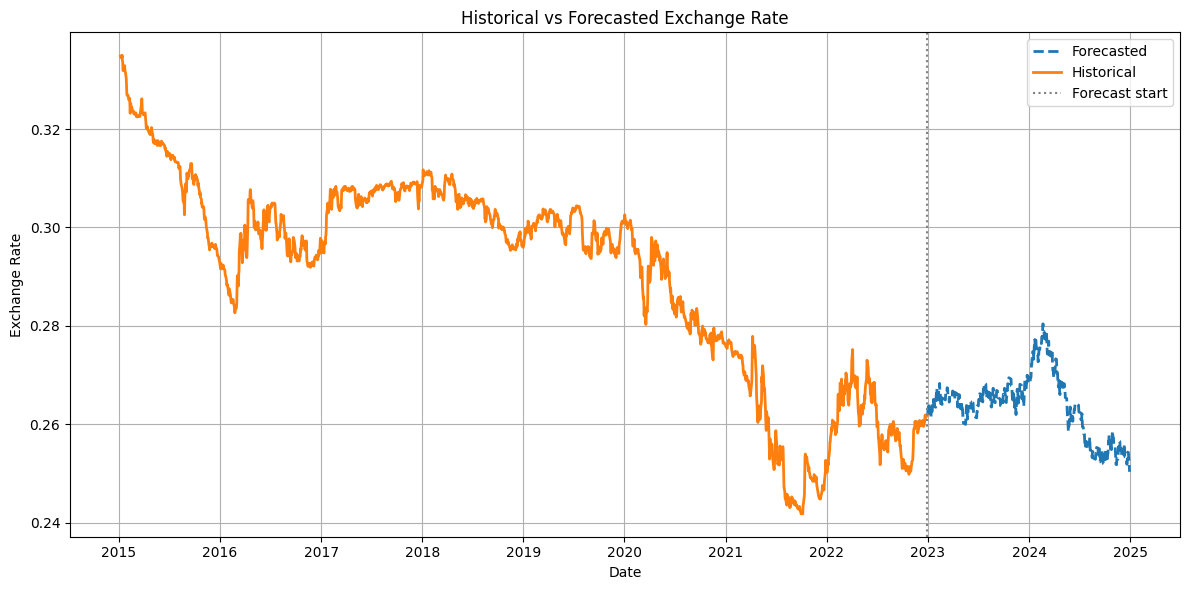

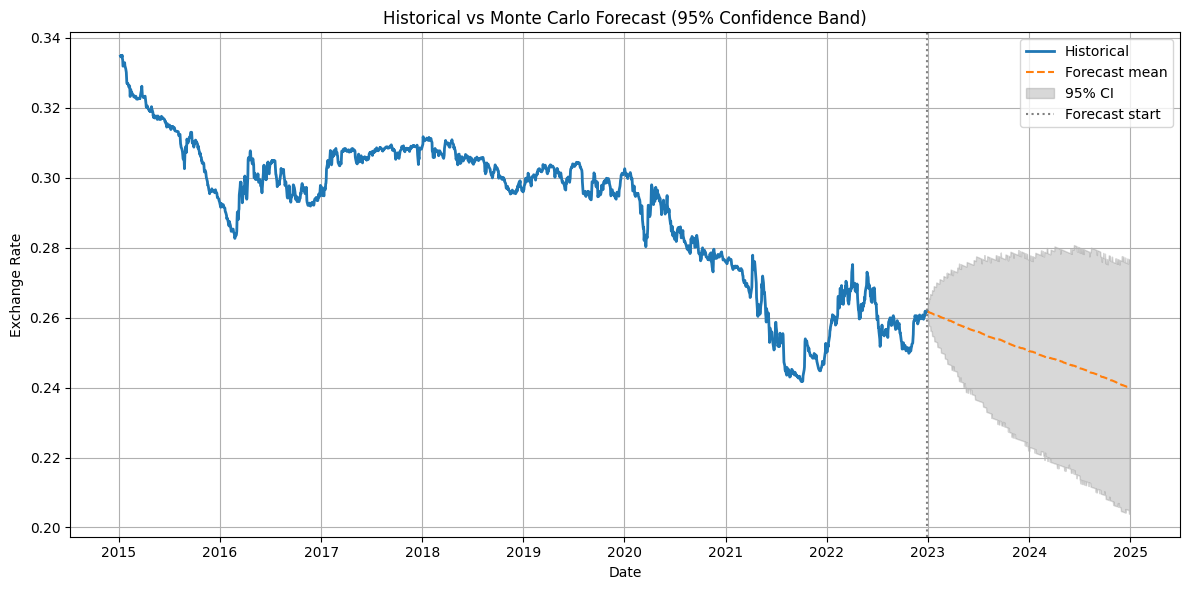

In [158]:
combined_df = plot_forecast_vs_history(train_df_dexuseu, df_forecast, rate_col='rate', rate_pred_col='rate_pred')
combined_df = plot_forecast_summary_vs_history(train_df_dexuseu, df_forecast_summary)


In [159]:
combined_df

,rate,source
date,,
2015-01-07,0.334784,Historical
2015-01-08,0.334560,Historical
2015-01-09,0.334896,Historical
2015-01-12,0.334560,Historical
2015-01-13,0.335008,Historical
...,...,...
2024-12-25,0.240037,Forecasted
2024-12-26,0.239995,Forecasted
2024-12-27,0.239969,Forecasted
